# Prediction of tram delays in Cracow

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
np.random.seed(0)

from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import cross_val_score

import xgboost as xgb

import eli5
import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', 1000)
pd.set_option('display.width', 1000)


In [2]:
df_train = pd.read_hdf('../input/tram.train.h5')
df_test = pd.read_hdf('../input/tram.test.h5')

print(df_train.shape, df_test.shape)

(175986, 11) (132166, 9)


## Concat datasets and leaving delay columns separated

Concatting `df_train` with ` df_test` and signing it to `df`.

In [3]:
delay = df_train['delay']
#df_train.drop('delay', axis=1, inplace=True) #Leaving y label - delay unchanged
delay

0           0
1           0
2           0
3           0
4           0
         ... 
308147      0
308148    660
308149    660
308150    660
308151    660
Name: delay, Length: 175986, dtype: int64

In [4]:
df = pd.concat([df_train, df_test])
df.shape

(308152, 11)

In [5]:
df.sample(3)

,id,delay,datetime,stop,stop_name,number,direction,planned_time,vehicle_id,trip_id,seq_num
46049,46049,180.0,2018-07-23 22:46:12,409,Centralna,22,Kombinat,2018-07-23 22:43:00,6.352185e+18,6351558574044899599,NaN
70448,70448,NaN,NaN,367,Francesco Nullo,14,Mistrzejowice,2018-07-24 14:09:00,6.352185e+18,6351558574044727817,18.0
82986,82986,NaN,NaN,89,Bronowice,4,Wzgórza K.,2018-07-24 18:33:00,6.352185e+18,6351558574044457485,4.0


Mean: 61.5168252020047
max: 1140
min: 0
std: 82.48747691641832
Q_1: 0.0
Median: 60.0
Q_3: 120.0
Odległość abbsolutna miedzy Q_1 i Q_3: 120.0


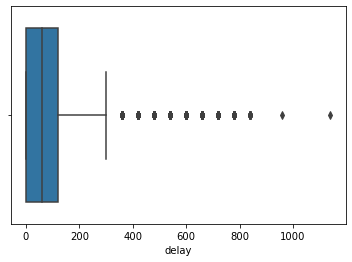

In [6]:
from scipy.stats import iqr

mean = np.mean(delay)
max = np.max(delay)
min = np.min(delay)
std = np.std(delay)
q_1 = np.quantile(delay, .25)
median = np.quantile(delay, .50)
q_3 = np.quantile(delay, .75)
iqr = iqr(delay) #odleglosc absolutna miedzy Q_1 i Q_3

print('Mean: {}'.format(mean))
print('max: {}'.format(max))
print('min: {}'.format(min))
print('std: {}'.format(std))
print('Q_1: {}'.format(q_1))
print('Median: {}'.format(median))
print('Q_3: {}'.format(q_3))
print('Odległość abbsolutna miedzy Q_1 i Q_3: {}'.format(iqr))

import seaborn as sns

sns.boxplot(x=delay)
plt.show()

### Dealing with features (`feature engineering`)

Krakow is one of the largest cities in Poland, which can result in streetcar delays caused by rush hour - when there are longer waits for public transportation.There are different dynamics during rush hour.

A hypothesis arises to show the model directly what time it is. <strong> We pull this hour from `planned_time` - the variable tells us what time the planned tram ride was. </strong>

Using `pd.to_datetime` we map planned_time to a datetime type, which allows us to work with dates more easily.

In [7]:
df.drop('id', axis=1, inplace=True)

In [8]:
df['planned_time'] = pd.to_datetime(df['planned_time'], format='%Y-%m-%d %H:%M:%S')
df['day'] = df['planned_time'].dt.dayofweek

df['month'] = df['planned_time'].dt.month

df['hour'] = df['planned_time'].dt.hour

df['minute'] = df['planned_time'].dt.minute

df['time_diff'] = df['planned_time'].diff()

In [9]:
df['time_diff'] = df['time_diff'].dt.total_seconds()

df['stop_diff'] = df['stop'].diff()
df['stop_hour'] = df['stop']/df['hour']

df['rush_hours'] = df['hour'].apply(lambda x: 1 if (x > 5 and x < 10) | (x > 14 and x < 19) else 0) # rush_hours
df['night_hours'] = df['hour'].apply(lambda x: 1 if (x < 6 or x > 21) else 0) # night_hours

In [10]:
df['vehicle_id_log'] = df['vehicle_id'].map(lambda x: np.log(x))

df['vehicle_id_cat'] = pd.factorize(df['vehicle_id_log'])[0]

In [11]:
len(df['planned_time'].unique()) 

# planned_time columns is not needed any more
#I used this column to extract every possible information 
#such as day, month, hour, minute, time_diff and so on.

df.drop('planned_time', axis=1, inplace=True)

### Bus stops
There are probably some streetcar stops that are more frequently used and prone to delay.
For extracting more data, you can collect more information about delays occurring at specific stops (e.g., average value, standard deviation).
Let's also count how often no delay occurred at a particular stop (zero delay) - `count_zeros_stopname_delay`.

In [12]:
def df_group_delay(df_train, groupby_feats):
    agg_params = {
        "mean_{}_delay".format("_".join(groupby_feats)): ("delay", "mean"),
        "median_{}_delay".format("_".join(groupby_feats)): ("delay", "median"),
        "count_{}_delay".format("_".join(groupby_feats)): ("delay", "count"),
        "std_{}_delay".format("_".join(groupby_feats)): ("delay", "std"),
        "count_zeros_{}_delay".format("_".join(groupby_feats)): ("delay", lambda vals: len([x for x in vals if x == 0]) ),
        "prob_zeros_{}_delay".format("_".join(groupby_feats)): ("delay", lambda vals: np.mean([x == 0 for x in vals]) ),
    }
    
    return df_train[groupby_feats + ["delay"]].groupby(groupby_feats).agg(**agg_params).reset_index()

### Converting object columns into dummies columns

In [13]:
df.select_dtypes('object')

,datetime,stop_name,direction
0,2018-07-23 06:00:47,Borsucza,Walcownia
1,2018-07-23 06:00:48,Smolki,Czerwone Maki P+R
2,2018-07-23 06:00:49,Filharmonia,Bronowice Małe
3,2018-07-23 06:00:51,Hala Targowa,Salwator
4,2018-07-23 06:00:52,Batorego,Bronowice Małe
...,...,...,...
308141,NaN,Bronowice,Bronowice Małe
308142,NaN,Kampus UJ,Czerwone Maki P+R
308143,NaN,Wesele,Bronowice Małe
308144,NaN,Bieżanowska,Kurdwanów P+R


In [14]:
print(df['direction'].value_counts(), '\n')

direction = pd.get_dummies(df['direction'], prefix = 'direction', drop_first=True)

df.drop('direction', axis=1, inplace=True)

Czerwone Maki P+R    36743
Bronowice Małe       35937
Krowodrza Górka      35372
Nowy Bieżanów P+R    22648
Wzgórza K.           22416
Borek Fałęcki        18488
Kurdwanów P+R        18293
Os.Piastów           18169
Salwator             16224
Mistrzejowice        15089
Mały Płaszów         13517
Bronowice            10259
Prokocim              9296
Kopiec Wandy          7965
Cichy Kącik           7480
Walcownia             6276
Łagiewniki            5410
Dworzec Tow.          5393
Cm. Rakowicki         1788
Kombinat              1389
Name: direction, dtype: int64 



In [15]:
print(df['stop_name'].value_counts(), '\n')

stop_name = pd.get_dummies(df['stop_name'], prefix = 'stop_name', drop_first=True)

df.drop('stop_name', axis=1, inplace=True)

Rondo Mogilskie                            6766
Dworzec Główny                             6699
Stradom                                    5062
Rondo Grzegórzeckie                        5004
Kabel                                      4800
Starowiślna                                4755
Rondo Czyżyńskie                           4516
Bieżanowska                                4318
Podgórze SKA                               4315
Teatr Bagatela                             4289
Stary Kleparz                              4131
Poczta Główna                              4131
Lubicz                                     4126
Dworzec Towarowy                           3722
Dworcowa                                   3674
Filharmonia                                3592
Korona                                     3571
Cmentarz Podgórski                         3564
Biprostal                                  3515
Bratysławska                               3454
Plac Wszystkich Świętych                

In [16]:
len(df['datetime'].unique()) 

# datatime column contains np.nan values when delay column (y label column) is also np.nan
# delay column is the result of subtraction between planned_time column and datatime column

df.drop('datetime', axis=1, inplace=True)

### NaN Values

['delay', 'seq_num', 'time_diff', 'stop_diff']


<AxesSubplot:>

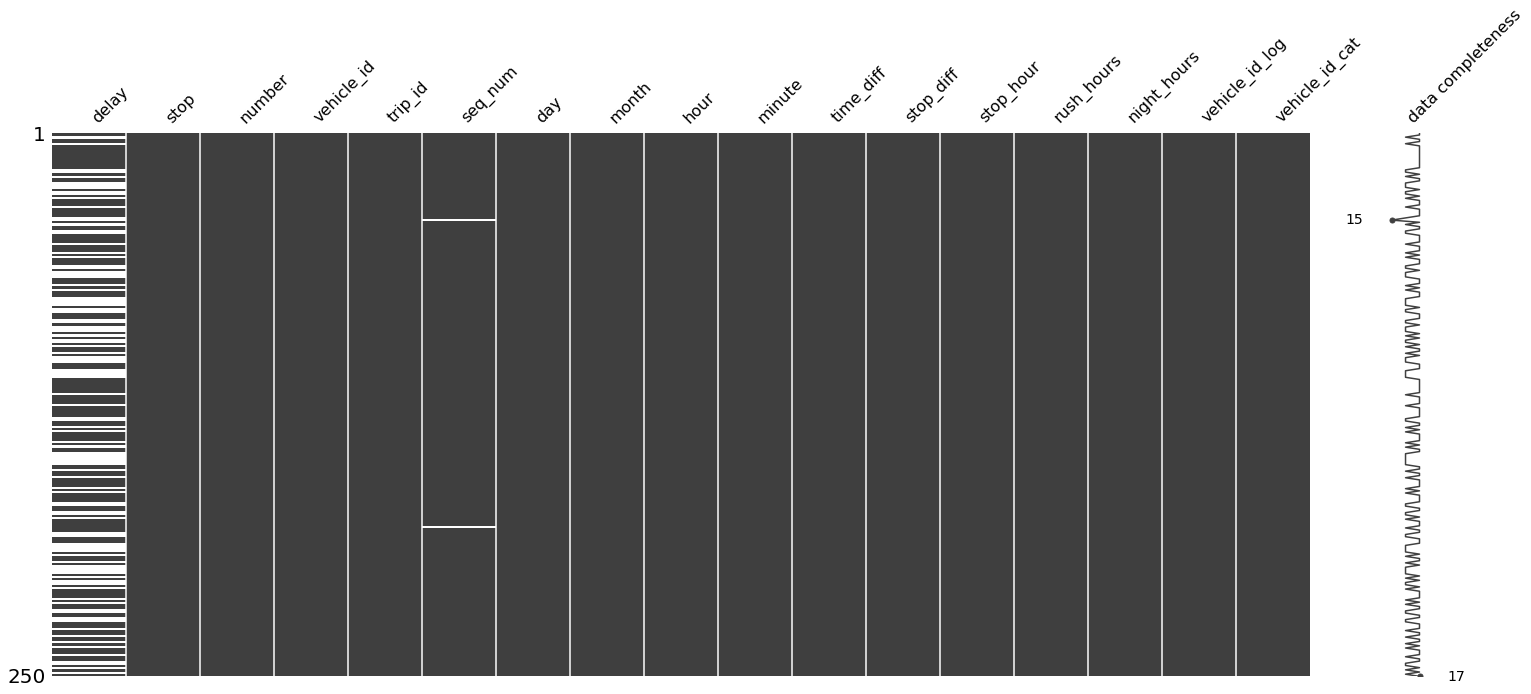

In [18]:
import missingno as msno

print(df.columns[df.isna().any()].tolist())
msno.matrix(df.sample(250), labels=True)

<AxesSubplot:xlabel='seq_num'>

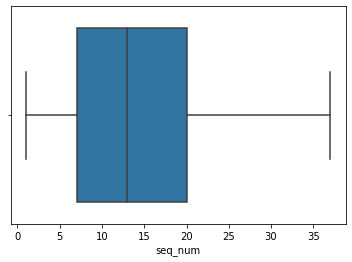

In [19]:
sns.boxplot(df['seq_num'])

In [20]:
print(df['seq_num'].value_counts(dropna=False))

df.dropna(subset=['seq_num'], inplace=True)

7.0     13410
1.0     12939
5.0     12813
10.0    12808
12.0    12527
11.0    12421
15.0    12383
16.0    12238
8.0     12227
13.0    12209
9.0     12103
17.0    11998
3.0     11990
4.0     11885
14.0    11582
6.0     11541
2.0     10810
18.0    10500
20.0     9137
19.0     9119
21.0     8883
22.0     8311
23.0     7797
25.0     7162
24.0     7024
27.0     5470
26.0     5233
28.0     3240
29.0     2909
31.0     2747
32.0     2633
30.0     2604
NaN      2382
33.0     1974
34.0     1819
35.0      994
36.0      258
37.0       72
Name: seq_num, dtype: int64


<AxesSubplot:xlabel='time_diff'>

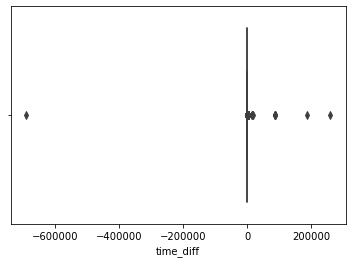

In [21]:
sns.boxplot(df['time_diff'])

In [22]:
print(df['time_diff'].value_counts(dropna=False))

df.dropna(subset=['time_diff'], inplace=True)

 0.0         83595
 60.0        58595
-60.0        56836
 120.0       29321
-120.0       28350
 180.0       13479
-180.0       12846
 240.0        6081
-240.0        5765
 300.0        2697
-300.0        2601
 360.0        1298
-360.0        1209
-420.0         683
 420.0         652
 480.0         365
-480.0         359
-540.0         244
 540.0         234
-600.0         126
 600.0         123
 660.0          66
-660.0          60
 720.0          48
-720.0          39
-780.0          32
 780.0          28
-840.0          10
 840.0          10
 86520.0         2
 NaN             1
-960.0           1
 16680.0         1
 15660.0         1
 15420.0         1
 1140.0          1
 15300.0         1
-900.0           1
 86400.0         1
-691620.0        1
 86640.0         1
 86820.0         1
-1080.0          1
 14280.0         1
 187800.0        1
 259080.0        1
Name: time_diff, dtype: int64


<AxesSubplot:xlabel='stop_diff'>

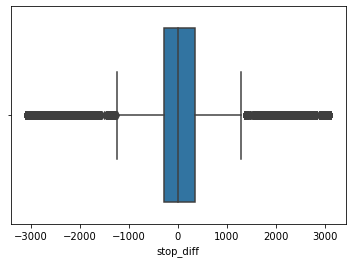

In [23]:
sns.boxplot(df['stop_diff'])

In [24]:
print(df['stop_diff'].value_counts(dropna=False))

df.dropna(subset=['stop_diff'], inplace=True)

 0.0       14361
-1.0        5140
 1.0        5102
 5.0        2934
 2.0        2922
           ...  
 2006.0        1
-2289.0        1
 2685.0        1
-800.0         1
-940.0         1
Name: stop_diff, Length: 3155, dtype: int64


['delay']


<AxesSubplot:>

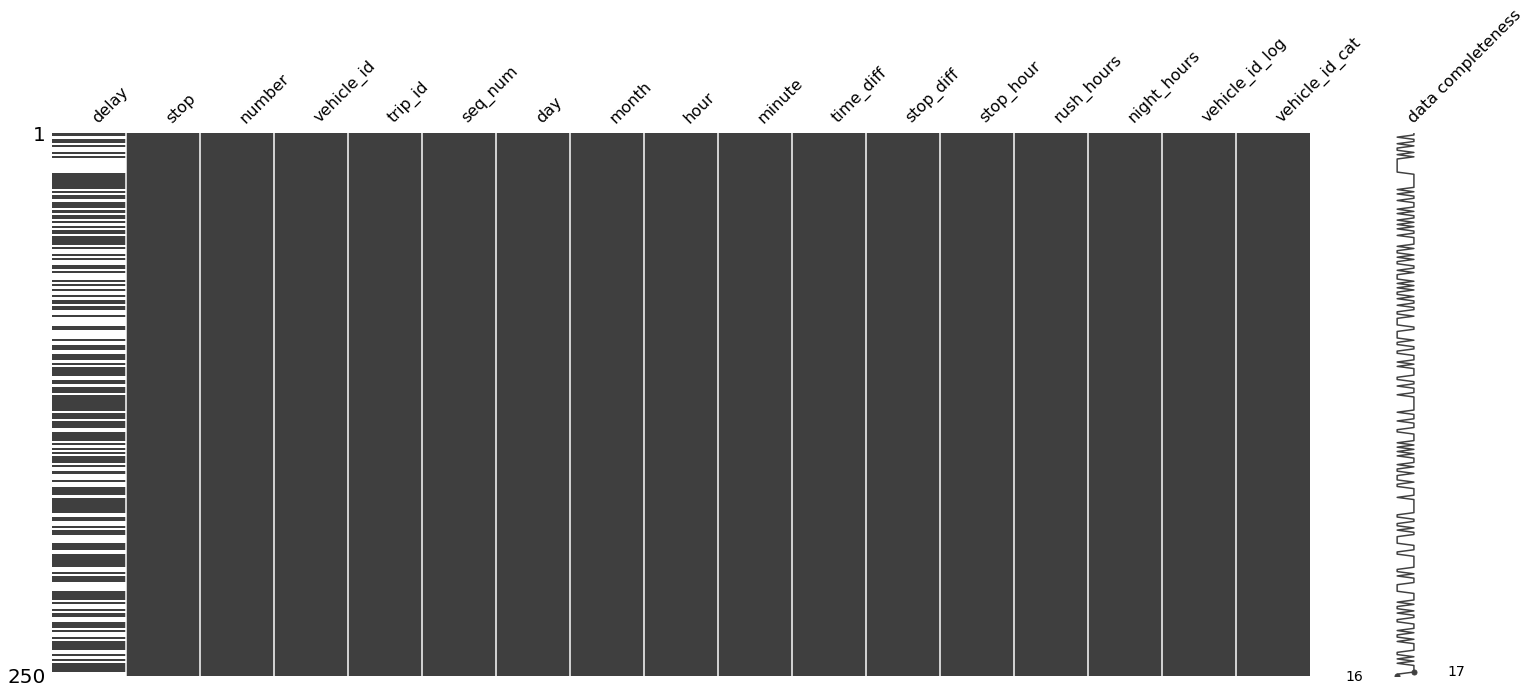

In [25]:
print(df.columns[df.isna().any()].tolist())
msno.matrix(df.sample(250), labels=True)

### Standardization of features

In [26]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 305769 entries, 1 to 308145
Data columns (total 17 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   delay           174650 non-null  float64
 1   stop            305769 non-null  int64  
 2   number          305769 non-null  int64  
 3   vehicle_id      305769 non-null  float64
 4   trip_id         305769 non-null  int64  
 5   seq_num         305769 non-null  float64
 6   day             305769 non-null  int64  
 7   month           305769 non-null  int64  
 8   hour            305769 non-null  int64  
 9   minute          305769 non-null  int64  
 10  time_diff       305769 non-null  float64
 11  stop_diff       305769 non-null  float64
 12  stop_hour       305769 non-null  float64
 13  rush_hours      305769 non-null  int64  
 14  night_hours     305769 non-null  int64  
 15  vehicle_id_log  305769 non-null  float64
 16  vehicle_id_cat  305769 non-null  int64  
dtypes: float64

In [27]:
print('Main df\'s dataframe contains {} columns'.format(len(df.columns)))
print('stop_name\'s dataframe contains {} columns'.format(len(stop_name.columns)))
print('direction\'s dataframe contains {} columns'.format(len(direction)))

Main df's dataframe contains 17 columns
stop_name's dataframe contains 153 columns
direction's dataframe contains 308152 columns


## Select features

In addition, we can ignore some features, because if you check them more carefully, it turns out that they do not contribute much.

In [28]:
df['delay'] = delay

y = df['delay'].dropna()

X = df[~df['delay'].isna()]
X.drop('delay', axis=1, inplace=True)

X_test = df[df['delay'].isna()]
X_test.drop('delay', axis=1, inplace=True)

In [29]:
from sklearn.model_selection import train_test_split
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.35)

print(X_train.shape, X_valid.shape, y_train.shape, y_valid.shape, )

(113522, 16) (61128, 16) (113522,) (61128,)


### Building the model

<strong>Due to the large amount of data/records, most of the models available in scikit-learn will not be able to learn the model!</strong> For that, we can still use the capabilities of the XGBoost library.

In [30]:
import xgboost as xgb


train_data = xgb.DMatrix(data=X_train,
                        label=y_train)

xgb_params = {'objective':'reg:linear',
         'max_depth':4}

xgb_model = xgb.train(params=xgb_params,
                      dtrain=train_data,
                      num_boost_round=10)

[10:20:37] WARNING: /workspace/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[10:20:40] WARNING: /workspace/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.


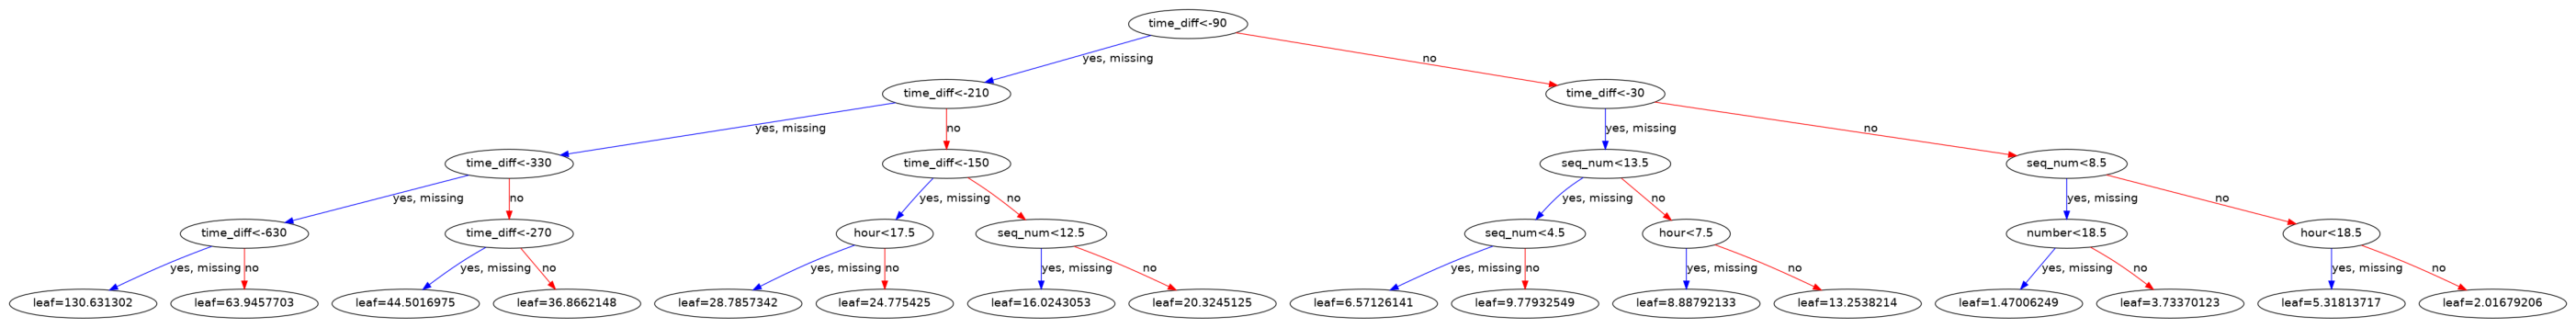

In [43]:
from matplotlib.pylab import rcParams
%matplotlib inline

rcParams['figure.figsize'] = 50,20
xgb.plot_tree(xgb_model, num_trees=2)
plt.savefig('plot_tree.png')
plt.show()

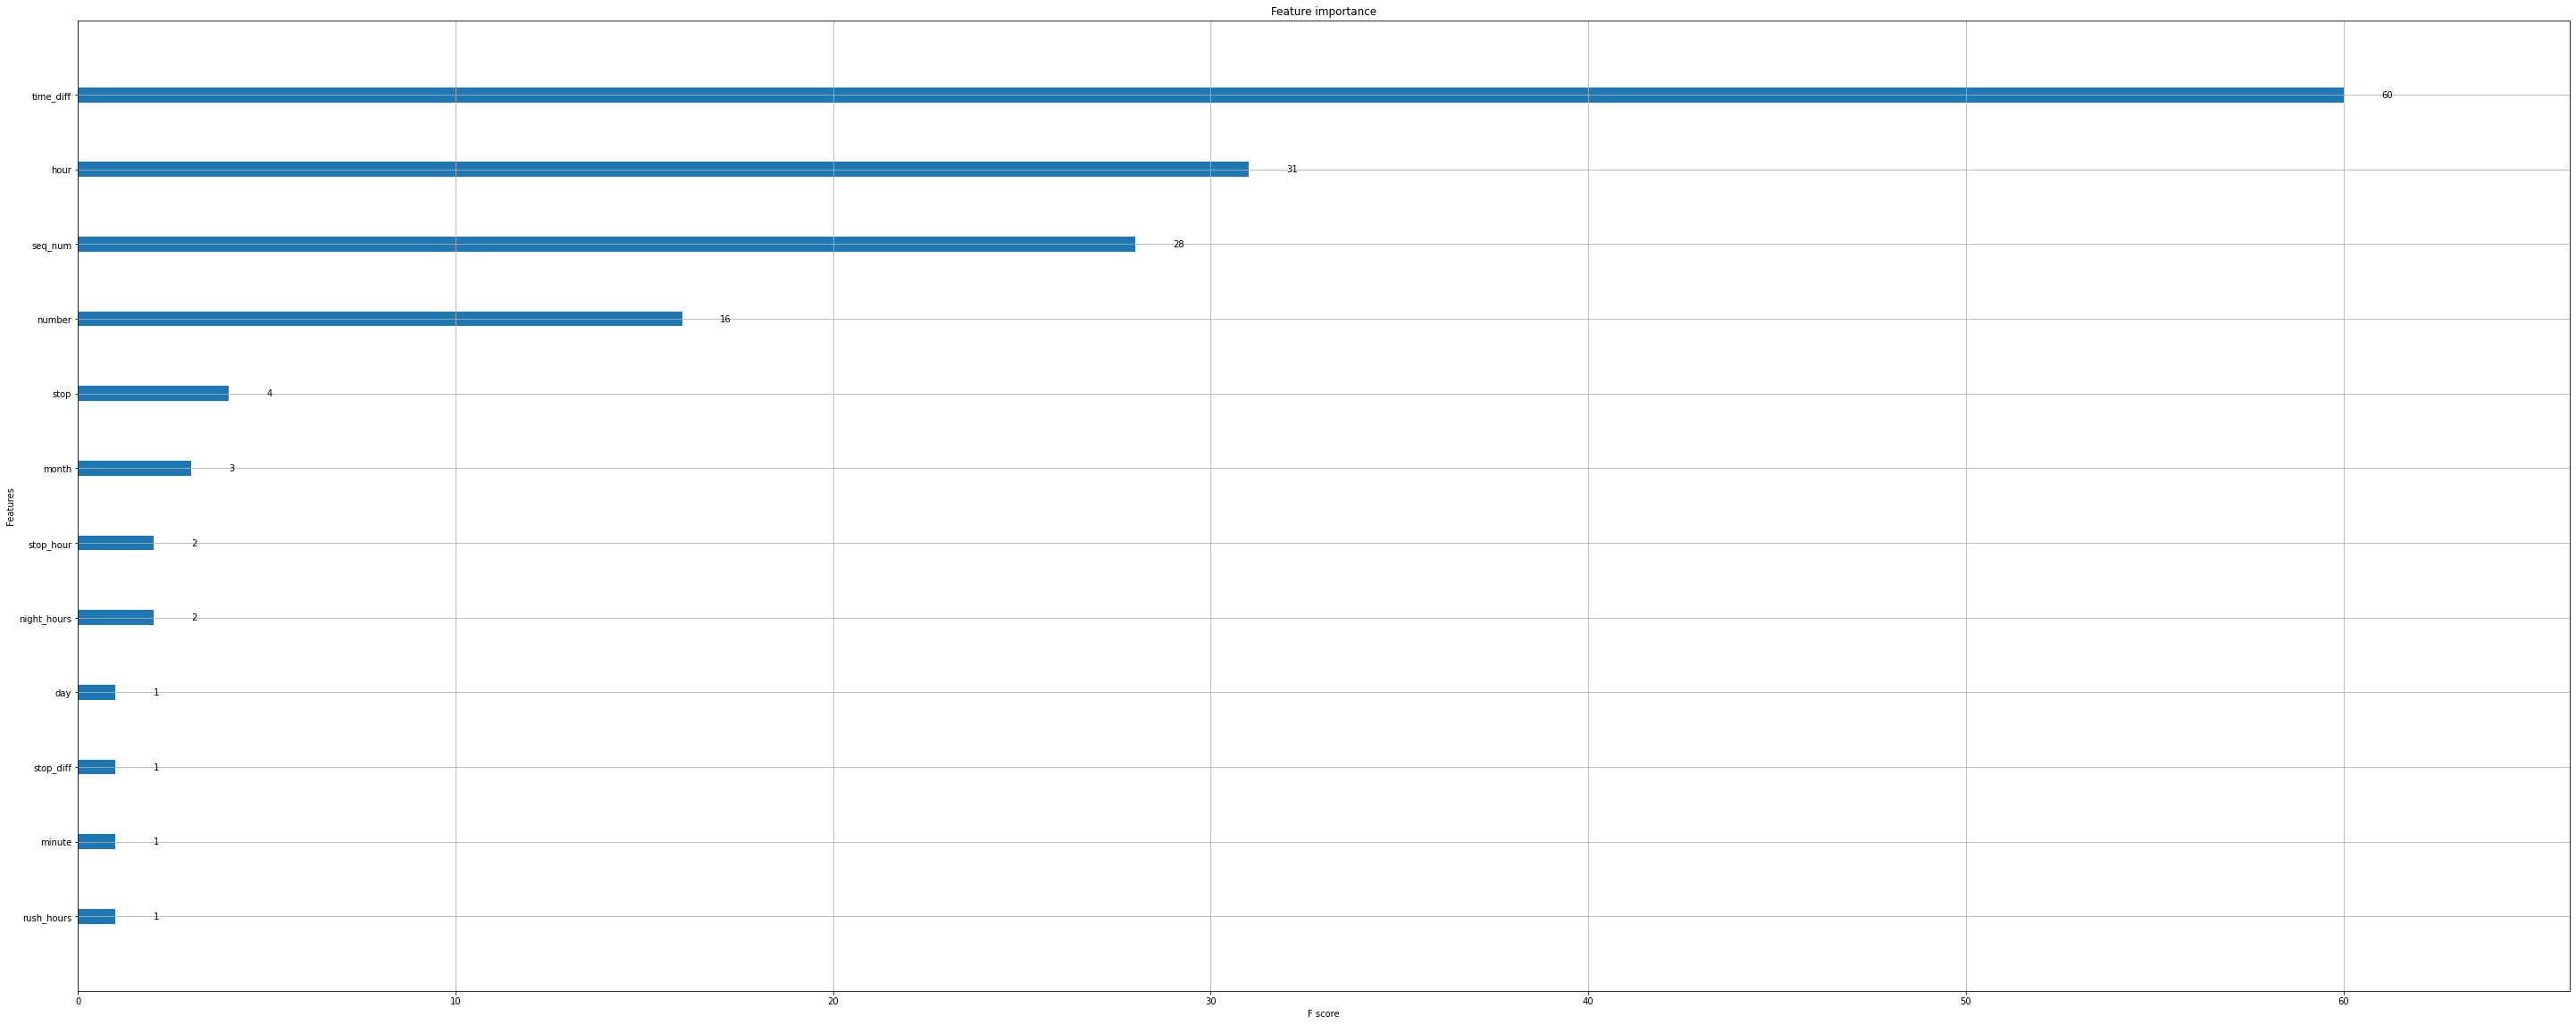

In [44]:
rcParams['figure.figsize'] = 50,20
xgb.plot_importance(xgb_model)
plt.savefig('plot_importance.png')
plt.show()

### Hyperparameter tuning on the XGBRegressor

In [33]:
from sklearn.model_selection import RandomizedSearchCV, KFold

kf = KFold(n_splits=10, shuffle=True, random_state=123)

params_xgbr = {'n_estimators': np.arange(50,350,50),
          'max_depth': [2,3,4,5,6],
         'learning_rate':[0.01,0.1,0.5,0.9],
         'subsample':[0.3,0.5,0.9]}

In [34]:
xgbr = xgb.XGBRegressor()

xgbr_cv = RandomizedSearchCV(xgbr, params_xgbr, cv=kf, n_jobs=-1)

xgbr_cv.fit(X_train,y_train)

y_pred_train = xgbr_cv.predict(X_train)
y_pred_valid = xgbr_cv.predict(X_valid)

print('Best params: {}'.format(xgbr_cv.best_params_))
print('MAE on train dataset: {}'.format(mean_absolute_error(y_train,y_pred_train)))
print('MAE on valid dataset: {}'.format(mean_absolute_error(y_valid,y_pred_valid)))

Best params: {'subsample': 0.9, 'n_estimators': 150, 'max_depth': 5, 'learning_rate': 0.5}
MAE on train dataset: 28.892229052740117
MAE on valid dataset: 31.043666506984472


### Cross validation on the XGBRegressor

In [36]:
import xgboost as xgb
from sklearn.model_selection import cross_val_score

In [37]:
model = xgb.XGBRegressor(subsample= 0.9, n_estimators= 150, max_depth= 5, learning_rate= 0.5)

In [38]:
scores = cross_val_score(model, X_train, y_train, cv=3, scoring="neg_mean_absolute_error")

In [39]:
print('mean of cross validation: {}'.format(-scores.mean()))
print('std of cross validation: {}'.format(scores.std()))

mean of cross validation: 31.462089456203035
std of cross validation: 0.06042392804400001
